In [1]:
import torch.nn as nn 
import torchvision
import torch 
from glob import glob
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import scipy.stats as st

In [2]:
# FOr raw data or v1
df = pd.read_csv("/home/shirshak/BPEye_Project_2024/zzz_tests/df_H_W_Mean-Intensity_labels.csv")
# df = df.drop(columns=["Mean Intensity Value R,G,B", "Mean Intensity Value", "label"], axis=1)
# df = df[:3000]

In [4]:
print((df['label'] == 'RG').sum())
print((df['label'] == 'NRG').sum())

3270
98172


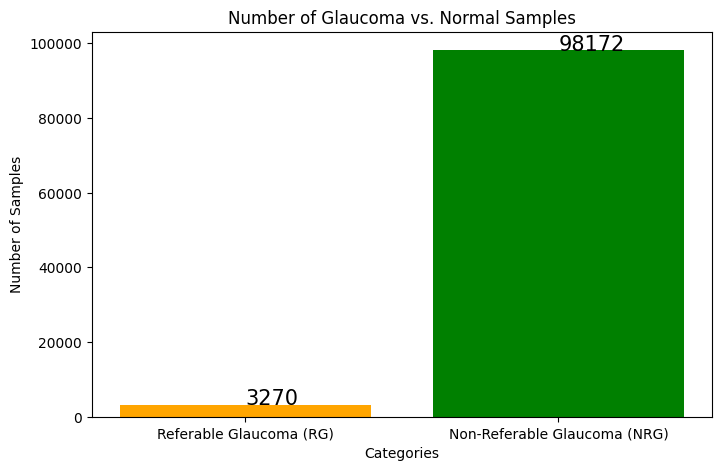

In [5]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], fontsize=15)

def data_imbalance_check(df):
    len_glaucoma = (df['label'] == 'RG').sum()
    len_normal = (df['label'] == 'NRG').sum()
    plt.figure(figsize=(8, 5))
    plt.bar(['Referable Glaucoma (RG)', 'Non-Referable Glaucoma (NRG)'], [len_glaucoma, len_normal], color=['orange', 'green'])
    addlabels(['Referable Glaucoma (RG)', 'Non-Referable Glaucoma (NRG)'], [len_glaucoma, len_normal])

    plt.xlabel('Categories')
    plt.ylabel('Number of Samples')
    plt.title('Number of Glaucoma vs. Normal Samples')
    plt.savefig("data_imbalance_check.jpg")

data_imbalance_check(df)

In [6]:
df['height'].min(), df['height'].max(), df['width'].min(), df['width'].max(), 

(215, 5183, 215, 5183)

In [7]:
# Extract x and y
x = df['height']
y = df['width']
# Define the borders
# deltaX = (max(x) - min(x))/10
# deltaY = (max(y) - min(y))/10
xmin = min(x) #- deltaX
xmax = max(x) #+ deltaX
ymin = min(y) #- deltaY
ymax = max(y) #+ deltaY
print(xmin, xmax, ymin, ymax)
# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = plt.figure(figsize=(15, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
ax.set_xlabel('Height', labelpad=10)
ax.set_ylabel('Width')
ax.set_zlabel('Density')
ax.set_title('KDE plot for Height-Width-count distribution')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(25, 15)

215 5183 215 5183


LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

In [7]:
print(xmin, xmax, ymin, ymax)

212 4000 320 6000


/tmp/ipykernel_1858848/3922595906.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df.groupby(['Height Range', 'Width Range']).size().reset_index(name='Count')


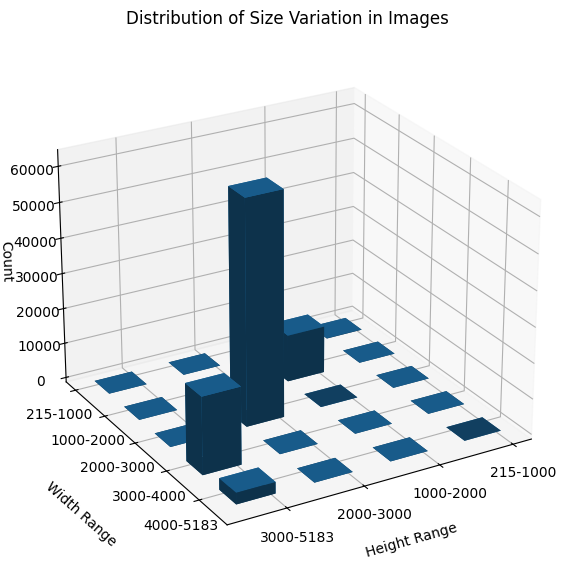

In [8]:
# Define range buckets for height and width
height_bins = [xmin-1, 1000, 2000, 3000, xmax] # we take xmin-1 because it doesnot include the minimum case when we only do xmin
width_bins = [ymin-1, 1000, 2000, 3000, 4000, ymax]

# Add bucketed columns
df['Height Range'] = pd.cut(df['height'], bins=height_bins, labels=[f"{xmin}-1000","1000-2000", "2000-3000", f"3000-{xmax}"])
df['Width Range'] = pd.cut(df['width'], bins=width_bins, labels=[f"{ymin}-1000","1000-2000", "2000-3000", "3000-4000", f"4000-{ymax}"])

# Count combinations of height and width ranges
count_data = df.groupby(['Height Range', 'Width Range']).size().reset_index(name='Count')

# Prepare data for 3D plotting
height_categories = np.array([f"{xmin}-1000","1000-2000", "2000-3000", f"3000-{xmax}"])
width_categories = np.array([f"{ymin}-1000","1000-2000", "2000-3000", "3000-4000", f"4000-{ymax}"])
height_indices = {cat: i for i, cat in enumerate(height_categories)}
width_indices = {cat: i for i, cat in enumerate(width_categories)}

count_data['Height Index'] = count_data['Height Range'].map(height_indices)
count_data['Width Index'] = count_data['Width Range'].map(width_indices)

# Extract x, y, z data for plotting
x = count_data['Height Index']
y = count_data['Width Index']
z = count_data['Count']

# Create 3D plot
fig = plt.figure(figsize=(18, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot data
ax.bar3d(x, y, np.zeros(len(z)), 0.5, 0.5, z, shade=True)

# Set tick labels for categorical axes
ax.set_xticks(range(len(height_categories)))
ax.set_xticklabels(height_categories)
ax.set_yticks(range(len(width_categories)))
ax.set_yticklabels(width_categories)

# Set axis labels
ax.set_xlabel('Height Range', labelpad=10)
ax.set_ylabel('Width Range', labelpad=20)
ax.set_zlabel('Count')

# ax.tick_params(axis='x', pad=10)
# ax.tick_params(axis='y', pad=10)

ax.view_init(25, 60)
plt.title('Distribution of Size Variation in Images')
plt.show()

In [9]:
df[df["Mean Intensity Value"] == df["Mean Intensity Value"].min()]

,Image Name,height,width,label,train_val_test,Mean Intensity Value,"Mean Intensity Value R,G,B",Height Range,Width Range
15950,TRAIN007472.jpg,2252,2252,NRG,train,3.379307,"[3.3921892642974854, 3.9466824531555176, 2.799...",2000-3000,2000-3000


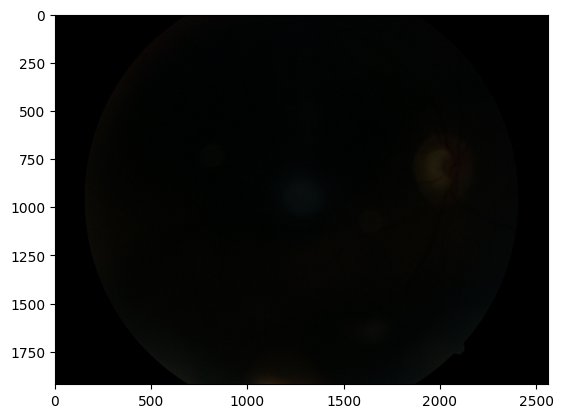

In [15]:
from torchvision.transforms import Lambda
from torchvision.io import read_image
import os 

img = Lambda(read_image)(os.path.join("/mnt/Enterprise2/shirshak/GLAUCOMA_DATASET_EYEPACS_AIROGS_ZENODO/overall_data/0/0/", df.loc[15950]['Image Name']))

plt.imshow(img.permute(1,2,0))

In [16]:
c,h,w = img.shape
left_half_axis_1d = img[0, h//2,:w//2].tolist()
top_half_axis_1d = img[0, :h//2,w//2].tolist()

right_half_axis_1d = img[0, h//2,w//2:].tolist()
bottom_half_axis_1d = img[0, h//2:,w//2].tolist()

In [17]:
torch.tensor(left_half_axis_1d).min(), torch.tensor(left_half_axis_1d).max()

(tensor(0), tensor(13))

In [18]:
torch.tensor(top_half_axis_1d).min(), torch.tensor(top_half_axis_1d).max()

(tensor(0), tensor(11))

In [19]:
torch.tensor(bottom_half_axis_1d).min(), torch.tensor(bottom_half_axis_1d).max()

(tensor(0), tensor(21))

In [20]:
torch.tensor(right_half_axis_1d).min(), torch.tensor(right_half_axis_1d).max()

(tensor(0), tensor(16))

In [21]:
# df[df['Height Range'].isnull()]
# df[df['Width Range'].isnull()]

In [22]:
df['Height Range'].isnull().sum(), df['Width Range'].isnull().sum()

(0, 0)

In [23]:
df['Height Range'].value_counts()

Height Range
2000-3000    63251
3000-5183    24874
1000-2000    13279
215-1000        38
Name: count, dtype: int64

In [24]:
df['Width Range'].value_counts()

Width Range
2000-3000    63251
3000-4000    21676
1000-2000    13279
4000-5183     3198
215-1000        38
Name: count, dtype: int64

In [25]:
df['label'].value_counts()

label
NRG    98172
RG      3270
Name: count, dtype: int64

In [26]:
height_ranges = [xmin, 1000, 2000, 3000, 4000]
width_ranges = [ymin, 1000, 2000, 3000, 4000, 6000]

In [27]:
for i in range(len(height_ranges)-1):
    for j in range(len(width_ranges)-1):
        print(f"Count of height[{height_ranges[i]}-{height_ranges[i+1]}] & width[{width_ranges[j]}-{width_ranges[j+1]}] : {((df['Height Range'] == f'{height_ranges[i]}-{height_ranges[i+1]}') & (df['Width Range'] == f'{width_ranges[j]}-{width_ranges[j+1]}')).sum()}")

Count of height[215-1000] & width[215-1000] : 38
Count of height[215-1000] & width[1000-2000] : 0
Count of height[215-1000] & width[2000-3000] : 0
Count of height[215-1000] & width[3000-4000] : 0
Count of height[215-1000] & width[4000-6000] : 0
Count of height[1000-2000] & width[215-1000] : 0
Count of height[1000-2000] & width[1000-2000] : 13279
Count of height[1000-2000] & width[2000-3000] : 0
Count of height[1000-2000] & width[3000-4000] : 0
Count of height[1000-2000] & width[4000-6000] : 0
Count of height[2000-3000] & width[215-1000] : 0
Count of height[2000-3000] & width[1000-2000] : 0
Count of height[2000-3000] & width[2000-3000] : 63251
Count of height[2000-3000] & width[3000-4000] : 0
Count of height[2000-3000] & width[4000-6000] : 0
Count of height[3000-4000] & width[215-1000] : 0
Count of height[3000-4000] & width[1000-2000] : 0
Count of height[3000-4000] & width[2000-3000] : 0
Count of height[3000-4000] & width[3000-4000] : 0
Count of height[3000-4000] & width[4000-6000] : 0


In [28]:
print(f"Count of height[{xmin}-1000] & width[{ymin}-1000] : {((df['Height Range'] == f'{xmin}-1000') & (df['Width Range'] == f'{ymin}-1000')).sum()}")
print(f"Count of height[1000-2000] & width[2000-3000] : {((df['Height Range'] == f'1000-2000') & (df['Width Range'] == f'2000-3000')).sum()}")

Count of height[215-1000] & width[215-1000] : 38
Count of height[1000-2000] & width[2000-3000] : 0


In [29]:
df['Mean Intensity Value'].min(), df['Mean Intensity Value'].max()

(3.3793070316314697, 172.21995544433594)

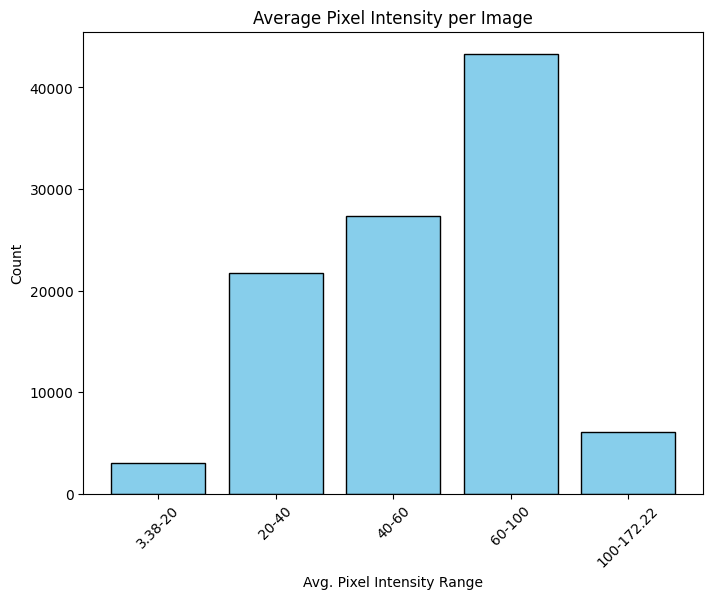

In [30]:
intensity_min = df['Mean Intensity Value'].round(2).min()
intensity_max = df['Mean Intensity Value'].round(2).max()

bins = [intensity_min-1, 20, 40, 60, 100, intensity_max] # because minimum value won't be taken so take range of min_value -1 
labels = [f'{intensity_min}-20', '20-40', '40-60', '60-100', f'100-{intensity_max}']

# Create a new column for the bucket ranges
df['Intensity Range'] = pd.cut(df['Mean Intensity Value'], bins=bins, labels=labels, include_lowest=True)

# Count the number of images in each bucket
distribution = df['Intensity Range'].value_counts().sort_index()

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(distribution.index, distribution.values, color='skyblue', edgecolor='black')
plt.xlabel('Avg. Pixel Intensity Range')
plt.ylabel('Count')
plt.title('Average Pixel Intensity per Image')
plt.xticks(rotation=45)
plt.show()

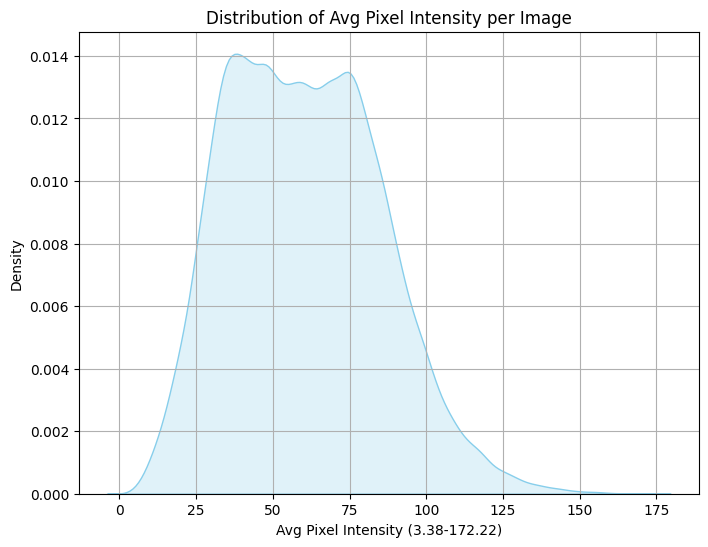

In [31]:
plt.figure(figsize=(8, 6))
sns.kdeplot(df['Mean Intensity Value'], fill=True, color='skyblue')

# Add labels and title
plt.xlabel(f'Avg Pixel Intensity ({intensity_min}-{intensity_max})')
plt.ylabel('Density')
plt.title('Distribution of Avg Pixel Intensity per Image')
plt.grid(True)
plt.show()

In [32]:
df["Intensity Range"].isnull().sum()

0

In [33]:
df

,Image Name,height,width,label,train_val_test,Mean Intensity Value,"Mean Intensity Value R,G,B",Height Range,Width Range,Intensity Range
0,TRAIN000006.jpg,1868,1868,NRG,test,87.783417,"[122.94204711914062, 82.32096862792969, 58.087...",1000-2000,1000-2000,60-100
1,TRAIN000016.jpg,1660,1660,NRG,test,47.872517,"[82.4787368774414, 50.213661193847656, 10.9251...",1000-2000,1000-2000,40-60
2,TRAIN000037.jpg,3029,3029,NRG,test,82.943741,"[131.36135864257812, 75.21183013916016, 42.258...",3000-5183,3000-4000,60-100
3,TRAIN000040.jpg,1567,1567,NRG,test,87.737770,"[119.17854309082031, 84.73666381835938, 59.298...",1000-2000,1000-2000,60-100
4,TRAIN000045.jpg,1869,1869,NRG,test,87.692268,"[122.82077026367188, 82.2409439086914, 58.0151...",1000-2000,1000-2000,60-100
...,...,...,...,...,...,...,...,...,...,...
101437,TRAIN100001.jpg,3414,3414,RG,val,85.385605,"[95.56610870361328, 90.94615173339844, 69.6445...",3000-5183,3000-4000,60-100
101438,TRAIN100005.jpg,2253,2253,RG,val,18.778584,"[29.503379821777344, 18.577823638916016, 8.254...",2000-3000,2000-3000,3.38-20
101439,TRAIN100175.jpg,3322,3322,RG,val,76.432320,"[143.85086059570312, 58.59889602661133, 26.847...",3000-5183,3000-4000,60-100
101440,TRAIN100891.jpg,2336,2336,RG,val,90.620712,"[122.28343963623047, 86.80567169189453, 62.773...",2000-3000,2000-3000,60-100


In [60]:
df[(df['Intensity Range']== "3.38-20")].sort_values(by=["Mean Intensity Value"], ascending=True).head(56)

,Image Name,height,width,label,train_val_test,Mean Intensity Value,"Mean Intensity Value R,G,B",Height Range,Width Range,Intensity Range
15950,TRAIN007472.jpg,2252,2252,NRG,train,3.379307,"[3.3921892642974854, 3.9466824531555176, 2.799...",2000-3000,2000-3000,3.38-20
95319,TRAIN043140.jpg,2254,2254,NRG,val,3.779368,"[5.564979076385498, 4.063329219818115, 1.70979...",2000-3000,2000-3000,3.38-20
50001,TRAIN051379.jpg,2254,2254,NRG,train,4.117471,"[7.567428112030029, 3.293816328048706, 1.49116...",2000-3000,2000-3000,3.38-20
88838,TRAIN005812.jpg,2253,2253,RG,train,4.353610,"[6.749726295471191, 4.410052299499512, 1.90105...",2000-3000,2000-3000,3.38-20
34189,TRAIN030981.jpg,2253,2253,NRG,train,4.407061,"[6.702207088470459, 4.5860772132873535, 1.9329...",2000-3000,2000-3000,3.38-20
56747,TRAIN060038.jpg,2251,2251,NRG,train,4.532966,"[7.815280914306641, 4.4447479248046875, 1.3388...",2000-3000,2000-3000,3.38-20
39113,TRAIN037356.jpg,2254,2254,NRG,train,4.589486,"[7.470143795013428, 4.417059898376465, 1.88125...",2000-3000,2000-3000,3.38-20
96443,TRAIN053999.jpg,2254,2254,NRG,val,4.679390,"[7.548269271850586, 4.653809070587158, 1.83609...",2000-3000,2000-3000,3.38-20
56582,TRAIN059831.jpg,2253,2253,NRG,train,4.832788,"[7.746695518493652, 5.264797687530518, 1.48687...",2000-3000,2000-3000,3.38-20
46607,TRAIN046987.jpg,2251,2251,NRG,train,4.905540,"[9.076202392578125, 4.500744342803955, 1.13967...",2000-3000,2000-3000,3.38-20


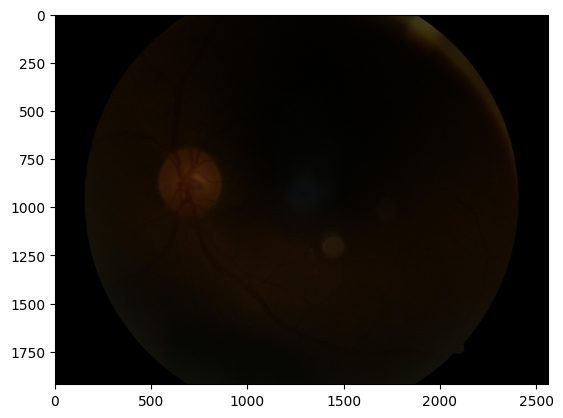

In [61]:
from torchvision.transforms import Lambda
from torchvision.io import read_image
import os 

img = Lambda(read_image)(os.path.join("/mnt/Enterprise2/shirshak/GLAUCOMA_DATASET_EYEPACS_AIROGS_ZENODO/overall_data/3/3/", df.loc[60067]['Image Name']))

plt.imshow(img.permute(1,2,0))

In [30]:
df[(df['Intensity Range']== "100-172.42")].sort_values(by=["Mean Intensity Value"], ascending=False)

,Image Name,height,width,label,Mean Intensity Value,"Mean Intensity Value R,G,B",Height Range,Width Range,Intensity Range
92012,TRAIN095084.jpg,2336,3504,NRG,172.419846,"[187.03688049316406, 168.8406524658203, 161.38...",2000-3000,3000-4000,100-172.42
73605,TRAIN076119.jpg,2592,3888,NRG,162.567902,"[182.0840606689453, 162.8305206298828, 142.789...",2000-3000,3000-4000,100-172.42
64991,TRAIN067237.jpg,2336,3504,NRG,160.992783,"[172.8934326171875, 159.76097106933594, 150.32...",2000-3000,3000-4000,100-172.42
56783,TRAIN058746.jpg,2336,3504,NRG,160.667740,"[173.8411407470703, 159.26210021972656, 148.89...",2000-3000,3000-4000,100-172.42
10221,TRAIN010570.jpg,2304,3456,NRG,159.144104,"[180.48126220703125, 152.0171356201172, 144.93...",2000-3000,3000-4000,100-172.42
...,...,...,...,...,...,...,...,...,...
88245,TRAIN091220.jpg,1944,2592,NRG,100.018578,"[137.38031005859375, 89.63467407226562, 73.040...",1000-2000,2000-3000,100-172.42
13129,TRAIN013575.jpg,2336,3504,NRG,100.007507,"[110.09376525878906, 99.1611099243164, 90.7676...",2000-3000,3000-4000,100-172.42
60476,TRAIN062541.jpg,2304,3456,NRG,100.007126,"[111.82811737060547, 98.34402465820312, 89.849...",2000-3000,3000-4000,100-172.42
67452,TRAIN069770.jpg,2336,3504,NRG,100.003479,"[112.07894134521484, 99.6649169921875, 88.2666...",2000-3000,3000-4000,100-172.42
